## BIOF509 Machine Learning Final Project
## Title: ML to predict Sjogren syndrome subgroups based on transcriptional profile 


Author: \
Agustin Alejandro Martinez Chibly 

Data Source: \
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE154926 \
A table with sample information was manually curated and available  in github: \
https://github.com/chiblyaa/GSE154926/blob/main/SampleInfo.csv

Project Description: \
This dataset contains Bulk RNA sequencing in minor salivary glands of Brazilian patients with primary Sjögren’s syndrome (SS) and healthy volunteers.
Study by: Contributor(s) Chiorini JA, Mo Y, Pranzatelli TJ, Michael DG, Ji Y, Rocha EM Available in GEO: GSE154926. \
We will use an unsupervised machine learning approach to identify subtypes of sjogren's syndrome (ss) based on their transcriptional profile. We will then generate a supervised model using Random Forest Classifiers (RFC) to predict subgroups of SS with the most significant featured identified in our unsupervised clustering approach.



## Load the data and packages
### Required packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import umap
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.metrics import explained_variance_score, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib as matplot

# Load csv data files containing sample information and gene expression matrix

In [377]:
# Load dataset from GitHub repository
# File also available from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE154926
url = "https://raw.githubusercontent.com/chiblyaa/GSE154926/main/RawData_GSE154926.csv"
dataset = pd.read_csv(url, index_col="Gene", header=0)
dataset = dataset.transpose()
dataset.head()

Gene,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,ENSG00000002079,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002726,ENSG00000002745,ENSG00000002746,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003096,ENSG00000003137,ENSG00000003147,ENSG00000003249,ENSG00000003393,ENSG00000003400,ENSG00000003402,...,ENSG00000283189,ENSG00000283194,ENSG00000283208,ENSG00000283217,ENSG00000283224,ENSG00000283229,ENSG00000283236,ENSG00000283241,ENSG00000283245,ENSG00000283251,ENSG00000283253,ENSG00000283263,ENSG00000283266,ENSG00000283294,ENSG00000283295,ENSG00000283299,ENSG00000283310,ENSG00000283332,ENSG00000283341,ENSG00000283368,ENSG00000283374,ENSG00000283382,ENSG00000283390,ENSG00000283396,ENSG00000283430,ENSG00000283467,ENSG00000283472,ENSG00000283473,ENSG00000283485,ENSG00000283495,ENSG00000283496,ENSG00000283549,ENSG00000283580,ENSG00000283590,ENSG00000283597,ENSG00000283602,ENSG00000283617,ENSG00000283632,ENSG00000283652,ENSG00000283663
BRA2,7029,4,263,426,61,17,966,876,151,153,123,3026,707,700,2,213,343,2276,342,402,0,110,1211,1064,89,4,0,9,43,419,350,92,1781,35,5,1503,44,249,307,1230,...,0,14,11,0,40,1510,3,63,0,0,0,0,9,1,0,0,0,0,3,0,2,0,312,3,200,4,0,5,119,0,0,10,2,0,0,1,8,0,15,0
BRA3,5320,40,742,389,98,94,3880,1361,147,160,262,2707,1031,575,11,252,343,4148,428,805,0,516,2648,6739,432,20,9,27,90,621,557,1173,3412,111,62,1813,68,354,593,2166,...,0,39,29,0,0,4821,2,36,72,0,15,0,16,0,0,24,0,0,15,0,0,0,702,16,2268,24,0,29,0,5,0,21,9,55,0,5,108,0,10,0
BRA4,3315,1,144,234,56,11,934,447,81,77,82,1489,407,496,2,34,188,2048,302,278,0,99,793,853,81,7,0,6,21,325,163,50,996,34,10,946,28,141,115,772,...,0,0,12,0,0,971,0,18,20,0,0,0,3,2,0,39,0,0,0,0,0,0,117,4,0,0,0,7,87,0,0,1,0,10,0,0,0,0,10,0
BRA31,3427,4,406,257,58,39,764,603,120,88,131,1769,505,354,1,82,244,1325,284,175,0,254,1542,1410,39,2,0,14,56,384,272,161,1786,46,0,1117,40,188,232,953,...,10,0,9,0,0,1277,0,87,2,0,0,6,0,1,0,0,0,0,4,0,0,0,292,4,545,19,0,6,42,0,0,9,3,0,0,4,8,0,0,0
BRA33,4740,13,313,429,106,53,3874,783,158,237,204,3424,1175,708,6,536,515,2541,546,314,0,183,2071,1715,195,26,0,26,91,622,340,273,3111,120,23,1462,43,415,429,2023,...,0,0,29,0,51,3945,7,64,21,0,29,0,0,2,0,26,0,0,4,0,0,0,171,7,573,16,0,19,151,0,0,7,2,25,0,1,0,0,8,2


The dataset contains 50 samples (7 controls and 43 SS patients) organized in rows and 34476 features (genes) as columns

# Clean, transform, and normalize data prior to machine learning


Eliminate low-expressing genes (expressed in <50% of samples)

In [378]:
# Dataset contains raw gene expression counts
# First we will filter out low-expressing genes, 
dataset.fillna(0, inplace=True)
dataset = dataset.loc[:, (dataset==0).mean() < .5,] # drop columns with 50% zero values
dataset.head()

Gene,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002726,ENSG00000002746,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003096,ENSG00000003137,ENSG00000003147,ENSG00000003249,ENSG00000003393,ENSG00000003400,ENSG00000003402,ENSG00000003436,ENSG00000003509,...,ENSG00000280893,ENSG00000280987,ENSG00000281005,ENSG00000281039,ENSG00000281195,ENSG00000281398,ENSG00000281501,ENSG00000281896,ENSG00000282034,ENSG00000282057,ENSG00000282246,ENSG00000282608,ENSG00000282619,ENSG00000282728,ENSG00000282772,ENSG00000282826,ENSG00000282915,ENSG00000282960,ENSG00000283050,ENSG00000283143,ENSG00000283147,ENSG00000283149,ENSG00000283182,ENSG00000283208,ENSG00000283229,ENSG00000283241,ENSG00000283245,ENSG00000283266,ENSG00000283341,ENSG00000283390,ENSG00000283396,ENSG00000283430,ENSG00000283467,ENSG00000283473,ENSG00000283485,ENSG00000283549,ENSG00000283580,ENSG00000283590,ENSG00000283602,ENSG00000283652
BRA2,7029,4,263,426,61,17,966,876,151,153,123,3026,707,700,2,213,343,2276,342,402,110,1211,1064,89,4,9,43,419,350,92,1781,35,5,1503,44,249,307,1230,606,194,...,81,2406,21,36,173,55,69,9,87,3,0,11,13,11,129,45,4,70,7,3,163,64,27,11,1510,63,0,9,3,312,3,200,4,5,119,10,2,0,1,15
BRA3,5320,40,742,389,98,94,3880,1361,147,160,262,2707,1031,575,11,252,343,4148,428,805,516,2648,6739,432,20,27,90,621,557,1173,3412,111,62,1813,68,354,593,2166,2037,412,...,217,2148,61,27,18,65,136,3,233,10,0,28,14,13,142,100,5,54,1,5,90,55,48,29,4821,36,72,16,15,702,16,2268,24,29,0,21,9,55,5,10
BRA4,3315,1,144,234,56,11,934,447,81,77,82,1489,407,496,2,34,188,2048,302,278,99,793,853,81,7,6,21,325,163,50,996,34,10,946,28,141,115,772,654,129,...,50,1062,19,26,84,10,35,4,62,3,12,13,5,3,208,37,5,19,0,5,100,29,34,12,971,18,20,3,0,117,4,0,0,7,87,1,0,10,0,10
BRA31,3427,4,406,257,58,39,764,603,120,88,131,1769,505,354,1,82,244,1325,284,175,254,1542,1410,39,2,14,56,384,272,161,1786,46,0,1117,40,188,232,953,465,176,...,105,1658,24,11,67,31,57,2,88,4,0,51,0,6,173,78,1,45,1,6,181,76,0,9,1277,87,2,0,4,292,4,545,19,6,42,9,3,0,4,0
BRA33,4740,13,313,429,106,53,3874,783,158,237,204,3424,1175,708,6,536,515,2541,546,314,183,2071,1715,195,26,26,91,622,340,273,3111,120,23,1462,43,415,429,2023,2081,274,...,119,3009,36,27,180,34,162,4,169,11,22,60,14,19,76,115,13,33,0,5,78,87,62,29,3945,64,21,0,4,171,7,573,16,19,151,7,2,25,1,8


Data frame is reduced to 18498 genes. \
Because we are working with gene expression data from different individuals, first we look at the distribution of our libraries. These are the sum of the expression values for all genes within each sample

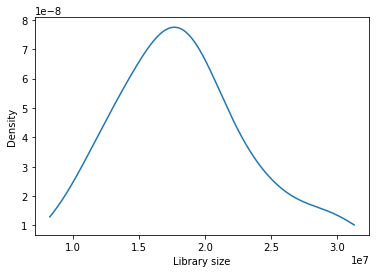

Library size statistics:
  min:  8225201
  mean: 18367311.38
  max:  31304488


In [379]:
# calculate gene counts per sample
''' 
we will transpose the dataframe temporarily 
to calculate library size and transform data
'''
dataset = dataset.transpose() 
total_counts = np.sum(dataset, axis=0) 

from scipy import stats

# we use a density plot to look at the distribution of counts
density = stats.kde.gaussian_kde(total_counts)
x = np.arange(min(total_counts), max(total_counts), 10000)

# Make the density plot
fig, ax = plt.subplots()
ax.plot(x, density(x))
ax.set_xlabel("Library size")
ax.set_ylabel("Density")

plt.show()

print(f'Library size statistics:\n  min:  {np.min(total_counts)}'
      f'\n  mean: {np.mean(total_counts)}'
      f'\n  max:  {np.max(total_counts)}')

Because of the big difference between the smallest and largest library sizes, we perform normalization by dividing the expression by the library size for each sample and multiplying by 1 million

In [380]:
# Normalize dataset by library size (total_counts)
norm_dataset = dataset / total_counts * 1000000
norm_dataset.head()

,BRA2,BRA3,BRA4,BRA31,BRA33,BRA36,BRA37,BRA41,BRA64,BRA11,BRA13,BRA14,BRA15,BRA16,BRA18,BRA19,BRA20,BRA70,BRA71,BRA72,BRA73,BRA74,BRA75,BRA76,BRA78,BRA79,BRA80,BRA81,BRA82,BRA83,BRA84,BRA87,BRA88,BRA89,BRA91,BRA92,BRA94,BRA96,BRA98,BRA99,BRA100,BRA102,BRA103,BRA104,BRA106,BRA107,BRA108,BRA109,BRA123,BRA124
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,327.638633,183.603433,270.505544,168.099716,259.839289,230.221283,35.969283,245.780579,75.977555,215.541898,220.711562,226.422551,315.807942,77.596433,116.438251,212.669612,181.538127,284.253134,231.371779,302.392026,146.566581,261.176809,85.952067,322.837701,246.403035,181.285522,247.357740,61.263659,144.191005,159.039523,311.905629,261.107758,30.964020,357.339896,54.667074,167.331733,241.832329,290.953588,283.514459,14.753030,208.152504,88.276279,144.668665,188.892004,277.118807,74.033979,168.550244,309.847337,322.189965,295.690085
ENSG00000000005,0.186450,1.380477,0.081600,0.196206,0.712639,0.206755,0.606942,1.039608,0.997244,0.199576,0.269160,0.921487,0.220690,0.000000,0.478677,0.000000,0.727243,0.392133,0.183156,0.574890,0.165145,0.109923,1.865519,0.541069,0.629583,0.000000,0.175224,0.258224,0.000000,0.299284,0.174590,1.285039,1.767177,0.236649,0.000000,0.000000,0.000000,0.055430,0.261159,0.000000,1.704052,1.039450,5.190133,0.202837,0.530509,0.000000,0.273887,2.382868,0.639689,1.464175
ENSG00000000419,12.259064,25.607847,11.750467,19.914936,17.158164,14.111004,25.842940,16.460455,22.375670,16.265430,15.611306,23.037178,30.675964,12.910556,21.061801,11.736955,33.544101,18.125277,17.308239,25.295150,12.633626,19.126585,17.549699,25.490351,15.582179,22.554302,12.966569,14.976996,29.178618,13.647351,12.832389,20.438245,16.672934,17.551463,14.166598,18.110407,27.046030,16.462796,20.892738,8.298579,30.156552,18.055637,17.434816,20.790798,23.294184,28.488275,16.104573,27.849773,22.637879,28.331781
ENSG00000000457,19.856887,13.425138,19.094509,12.606252,23.517100,19.434935,22.584621,27.939456,6.606744,21.604084,17.656925,23.563742,19.788571,2.395773,6.940821,16.585555,5.454325,14.770358,14.194588,15.973723,14.367654,16.158666,2.280079,21.462395,17.156136,7.173606,18.456918,4.454365,4.741525,18.495752,26.625026,26.190326,4.225859,20.943431,8.111520,22.701184,8.164839,22.116685,21.885143,4.610322,16.265949,3.849816,27.663914,20.841507,10.031450,10.957029,18.733891,16.009896,27.328930,32.943931
ENSG00000000460,2.843357,3.382169,4.569626,2.844991,5.810752,3.514829,11.436060,4.894819,0.373967,2.993637,3.176093,4.212513,3.751737,1.330985,2.333552,1.939440,2.727163,1.829956,3.617330,3.572529,2.890045,4.232032,0.552746,5.170213,4.485779,2.857284,2.686766,1.678456,0.000000,5.985680,4.015578,4.773003,0.537837,4.259681,0.799727,4.422309,5.103024,3.048666,3.342838,0.922064,2.478621,0.346483,7.356888,6.085112,0.626966,2.783678,2.957983,2.680727,7.498575,5.783490


In [381]:
'''
Because genes are expressed in different scales
we log-transform our data so that all can be
weighted similarly to determine the most important
features during dimensionality reduction 
'''
dataset = norm_dataset
#Log2 transform our dataset
dataset[dataset == 0] = 0.1 #remove zeroes to avoid getting -Inf values
dataset = dataset.applymap(np.log2)
dataset.fillna(0, inplace=True)
dataset.iloc[:,0:5].describe()

,BRA2,BRA3,BRA4,BRA31,BRA33
count,18498.000000,18498.000000,18498.000000,18498.000000,18498.000000
mean,1.614322,2.242529,1.810661,1.547709,2.449719
std,3.270204,3.178379,3.174955,3.154150,3.155631
min,-4.423142,-4.856761,-3.615279,-4.349557,-4.189196
25%,-0.963710,0.001220,-0.615279,-0.890125,0.203122
50%,1.898786,2.565297,2.192076,1.820368,2.822032
75%,4.060674,4.483089,4.192076,3.850115,4.767906
max,17.937176,17.476370,18.484189,18.560040,17.105918


Now that all genes are within a similar range, we transpose the dataframe to its original shape with genes in columns and proceed to scale our data prior to dimensionality reduction

### Scale using StandardScaler

In [382]:
# save our tranformed data with different name for manipulation
clean_data = dataset.transpose()

In [383]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_for_scaling = clean_data.values 
scaled_data = scaler.fit_transform(data_for_scaling)
print(scaled_data[0:5])

[[0.97277388 0.26722432 0.27934405 ... 0.         0.         0.4799734 ]
 [0.79107019 0.70825799 0.80672489 ... 0.93875857 0.43734724 0.30572233]
 [0.91265329 0.08518962 0.24900807 ... 0.6695126  0.25504985 0.51810553]
 [0.7633908  0.27846048 0.62671841 ... 0.         0.48025867 0.        ]
 [0.90003131 0.56259767 0.52004718 ... 0.83487176 0.05418386 0.36485134]]


In [384]:
pd.DataFrame(scaled_data).iloc[0:,0:10].describe()

,0,1,2,3,4,5,6,7,8,9
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.769855,0.402743,0.583159,0.663752,0.688069,0.401037,0.533882,0.523946,0.568331,0.703834
std,0.215439,0.237416,0.219820,0.252177,0.190597,0.271395,0.212797,0.183938,0.191547,0.184720
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.717316,0.243558,0.451404,0.496930,0.667824,0.053871,0.413270,0.458994,0.500847,0.620209
50%,0.845107,0.344781,0.557632,0.749358,0.725365,0.431171,0.538644,0.564352,0.575171,0.743081
75%,0.918337,0.565949,0.736944,0.841395,0.801783,0.594055,0.681951,0.621183,0.701094,0.830766
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Dimensionality reduction and supervised clustering

In [386]:
# First, we load file with sample annotations for supervised analysis
url = "https://raw.githubusercontent.com/chiblyaa/GSE154926/main/SampleInfo.csv"
df2 = pd.read_csv(url, index_col="Sample", header=0)

# The Dx column of df2 contains information about diagnosis which we'll use for supervised analysis
# We use Dx as a categorical label and save it to the variable target
df2["Dx"] = pd.Categorical(df2["Dx"])
df2["Dx"] = df2["Dx"].cat.codes
target = df2["Dx"]
df2.head(10)

,Dx,Age
Sample,,
BRA2,0,21
BRA3,0,59
BRA4,0,71
BRA31,0,24
BRA33,0,61
BRA36,0,14
BRA37,0,52
BRA41,1,53
BRA64,1,55


### Dimensionality Reduction with UMAP


In [328]:
data_reducer = umap.UMAP()
umap_data = data_reducer.fit_transform(scaled_data)
scaled_umap_data = scaler.fit_transform(umap_data)
reduced_df = pd.DataFrame(umap_data,columns=['UMAP Dim. #1', 'UMAP Dim. #2'])

print(reduced_df)

    UMAP Dim. #1  UMAP Dim. #2
0       6.453094     -1.820773
1       8.224390     -4.096200
2       6.698324     -1.271361
3       7.548268     -1.336212
4       6.710919     -4.595238
5       6.964326     -1.545603
6       6.876379     -4.970291
7       6.937969     -4.053091
8       9.471399     -1.482842
9       5.770037     -3.660311
10      6.330625     -3.453405
11      6.155088     -4.910115
12      8.001007     -4.522505
13      9.024473     -0.545171
14      8.620220     -1.541500
15      6.430542     -1.524331
16      8.403818     -1.202580
17      7.384621     -1.741206
18      7.966340     -2.446512
19      7.997940     -3.041372
20      6.381934     -1.972505
21      7.039830     -3.012467
22      9.124789     -1.117755
23      7.335962     -4.269927
24      7.226494     -3.637904
25      8.214360     -1.643392
26      6.887092     -1.902426
27      8.782846     -0.836891
28      8.153559     -2.273994
29      6.005983     -3.288587
30      5.844155     -4.615763
31      

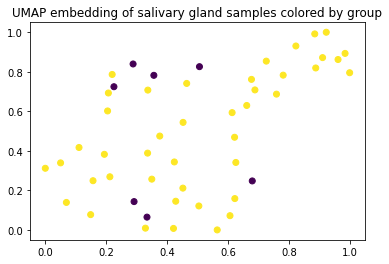

In [329]:
plt.scatter(scaled_umap_data[:,0], scaled_umap_data[:,1], c=target)
plt.title('UMAP embedding of salivary gland samples colored by group');

UMAP reduction did not perform well to separate samples by treatment. \
We will try with PCA

## PCA reduction

In [387]:
data_reducer = PCA(n_components=10)
pca_data = pd.DataFrame(data_reducer.fit_transform(scaled_data))
norm_pca = (pca_data-pca_data.min())/(pca_data.max()-pca_data.min()) 
norm_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,0.313544,0.069955,0.422663,0.344112,0.206942,0.298692,0.425098,0.309076,0.321912,0.491050
1,0.259566,0.742954,0.241945,0.208881,0.306472,0.392644,0.562516,0.344836,0.476264,0.167684
2,0.271445,0.184030,0.458566,0.385125,0.202087,0.502854,0.460603,0.250973,0.337442,0.107785
3,0.420684,0.229488,0.446976,0.277859,0.271114,0.194759,0.610918,0.580171,0.334314,0.630787
4,0.109239,0.508076,0.445074,0.296474,0.225375,0.253207,0.438622,0.222235,0.388121,0.172423


In [388]:
''' This loop gives us the top feature of each component using the argmax function '''
top_features = [np.abs(data_reducer.components_[i]).argmax() for i in range(data_reducer.components_.shape[0])]

''' Now, we go back to our original feature names (columns of our dataset), and get the names of the 10 key features '''
top_feature_names = [list(clean_data.columns)[top_features[i]] for i in range(data_reducer.components_.shape[0])]

''' printing the names '''
for n,name in enumerate(top_feature_names):
    print("#" + str(n) + ": " + str(name))

#0: ENSG00000214262
#1: ENSG00000120306
#2: ENSG00000226054
#3: ENSG00000077454
#4: ENSG00000165300
#5: ENSG00000124256
#6: ENSG00000166257
#7: ENSG00000258790
#8: ENSG00000255819
#9: ENSG00000111700


We perform k-means clustering with PCA-reduced and non-reduced data to evaluate performance of data reduction

In [390]:
## perform k means clustering
from sklearn.cluster import KMeans

kmeans_pred_scaled = []
kmeans_pred_pca = []
ks = [2, 3, 4] 

for k in ks:
    model = KMeans(n_clusters=k)
    kmeans_pred_pca.append(model.fit_predict(norm_pca))
    kmeans_pred_scaled.append(model.fit_predict(scaled_data))

n_correct_pca = np.max([(kmeans_pred_pca[0] == target).sum(), (kmeans_pred_pca[1] != target).sum()])
print("Accuracy after PCA: {}".format(n_correct_pca / len(target)))

n_correct_scaled = np.max([(kmeans_pred_scaled[0] == target).sum(), (kmeans_pred_scaled[1] != target).sum()])
print("Accuracy without PCA: {}".format(n_correct_scaled / len(target)))

Accuracy after PCA: 0.68
Accuracy without PCA: 0.58


In [391]:
''' This loop gives us the top feature of each component using the argmax function '''
top_features = [np.abs(data_reducer.components_[i]).argmax() for i in range(data_reducer.components_.shape[0])]

''' Now, we go back to our original feature names (columns of our dataset), and get the names of the 10 key features '''
top_feature_names = [list(clean_data.columns)[top_features[i]] for i in range(data_reducer.components_.shape[0])]

''' printing the names '''
for n,name in enumerate(top_feature_names):
    print("#" + str(n) + ": " + str(name))

''' finally, extract those 10 features from the original dataset '''
newdata = clean_data[top_feature_names]
print(newdata)

#0: ENSG00000214262
#1: ENSG00000120306
#2: ENSG00000226054
#3: ENSG00000077454
#4: ENSG00000165300
#5: ENSG00000124256
#6: ENSG00000166257
#7: ENSG00000258790
#8: ENSG00000255819
#9: ENSG00000111700
Gene    ENSG00000214262  ENSG00000120306  ...  ENSG00000255819  ENSG00000111700
BRA2           4.263358         4.695799  ...        -2.423142        -2.423142
BRA3          -3.321928         7.210001  ...         0.313164         0.898126
BRA4           4.697604         5.085161  ...         0.472184         0.192076
BRA31          0.779726         5.222196  ...        -1.027629        -3.321928
BRA33          2.822032         6.026337  ...        -0.488756         0.980729
BRA36          4.391327         4.981020  ...        -3.321928        -2.274008
BRA37          4.664698         7.537266  ...         1.851881        -3.321928
BRA41          4.590018         5.796382  ...        -2.528923         2.025666
BRA64         -3.321928         7.177171  ...         0.388336        -4.003981


# Test different machine learning models with the reduced dataset (newdata)

In [392]:
# Add the Dx column with diagnosis to newdata
# We reload the SampleInfo dataframe to use label from original file
url = "https://raw.githubusercontent.com/chiblyaa/GSE154926/main/SampleInfo.csv"

sampleinfo = pd.read_csv(url, index_col="Sample", header=0)
sampleinfo.head()
test_data = pd.concat([sampleinfo.reindex(newdata.index), newdata], axis=1)
test_data.head()

,Dx,Age,ENSG00000214262,ENSG00000120306,ENSG00000226054,ENSG00000077454,ENSG00000165300,ENSG00000124256,ENSG00000166257,ENSG00000258790,ENSG00000255819,ENSG00000111700
BRA2,Control,21,4.263358,4.695799,-0.615787,2.542642,-0.175215,0.898786,1.746783,-2.101214,-2.423142,-2.423142
BRA3,Control,59,-3.321928,7.210001,0.465167,2.509561,-1.049406,1.801450,1.728201,0.001220,0.313164,0.898126
BRA4,Control,71,4.697604,5.085161,-3.321928,2.514004,-0.293351,0.085161,2.493246,1.706649,0.472184,0.192076
BRA31,Control,24,0.779726,5.222196,-0.542202,1.581180,0.042760,2.520808,2.093386,-3.321928,-1.027629,-3.321928
BRA33,Control,61,2.822032,6.026337,0.565692,1.855199,0.395767,1.940087,1.765001,1.643694,-0.488756,0.980729


### Create training and validation splits for ML

Because our dataset has a low number of instances in the control class, we will split the dataset 50:50 

In [393]:
# Split-out validation dataset
array = test_data.values
X = array[:,2:]
y = array[:,0:1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, train_size=0.50, random_state=123) #use random state with favorite number for reproducibility

Load libraries to perform different ML models and compare their accuracy

In [394]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

We will compare performance of 6 algorithnms using a k-fold cross validation with 3 splits. We can't do too many splits because one class (control group) has too few instances. The tested algorithms will be: \
Logistic Regression (LR) \
Linear Discriminant Analysis (LDA) \
K-Nearest Neighbors (KNN) \
Desicion Tree Classifier (DTC) \
Gaussian Naive Bayes (NB) \
Support Vector Machines (SVM) \

LR: Accuracy: 0.879630 (+/- 0.006547)
LDA: Accuracy: 0.842593 (+/- 0.045831)
KNN: Accuracy: 0.879630 (+/- 0.006547)
DTC: Accuracy: 0.921296 (+/- 0.055940)
NB: Accuracy: 0.879630 (+/- 0.006547)
SVM: Accuracy: 0.800926 (+/- 0.053592)


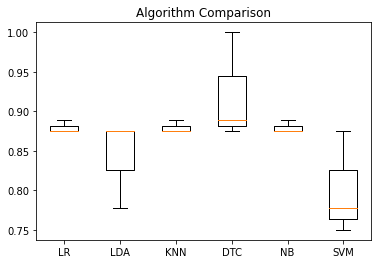

In [399]:
# create a list with the different algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='linear')))
# Use for loop to test each of the models
# a random state seed is set for reproducibility
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=3, random_state=15, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train.ravel(), cv=kfold, scoring='accuracy') #use ravel to convert to array
	results.append(cv_results)
	names.append(name)
	print('%s: Accuracy: %f (+/- %f)' % (name, cv_results.mean(), cv_results.std()))
 
# Use a box plot to graph the performance from each model
from matplotlib import pyplot
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

The majority of methods performed reasonably well with the exception of SVM.
DecisionTreeClassifier had the highest accuracy albeit with some variation

## Predict Sjogren syndrome using Decision Trees

In [400]:
from sklearn import metrics
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_validation)
print("Accuracy:",metrics.accuracy_score(Y_validation, y_pred))

Accuracy: 0.8


Print out the decision tree

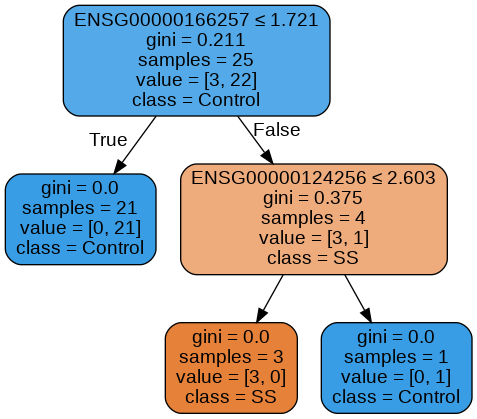

In [401]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = top_feature_names,class_names=['SS','Control'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [402]:
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.84
[[ 0  4]
 [ 0 21]]
              precision    recall  f1-score   support

     Control       0.00      0.00      0.00         4
          SS       0.84      1.00      0.91        21

    accuracy                           0.84        25
   macro avg       0.42      0.50      0.46        25
weighted avg       0.71      0.84      0.77        25



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
